<center>
    <h1 style="width: 90%">Understanding Relationships Between Professor Info and Course Enrollment Rates in the Computer Science Department at the University of Maryland, College Park</h1>
    <h2 style="width: 90%">By Wesley Smith, Franco Edah, and Ohsung Kwon</h2>
</center>

When given the ability of choice, people nearly always seek out the best possible selection to ensure their own success. As university students, even within our course selections, we seek to make the best decisions possible. Students commonly speak about checking grade data on [PlanetTerp](https://planetterp.com) and looking at professor reviews. In this project, we are looking to better understand the relationship between average GPA and average rating compared to course enrollment rates. Our analysis is going to concentrate on the Department of Computer Science at the University of Maryland, College Park because it is a department that we can best understand ourselves and our peers.

# Obtaining our Data

Before we are able to begin our analysis, we first need to retrieve the publicly available data about professors and courses within the Computer Science Department. Using APIs developed by our peer students at the University hosted on [umd.io](https://umd.io) and [PlanetTerp](https://planetterp.com), we are able to secure the necessary data to conduct our analyses.

Fetching large amounts of data from the umd.io and PlanetTerp APIs as we were working on this project turned out to be costly both in terms of the amount of time we were waiting for data to process, and costly for the APIs themselves, with us sometimes being rate-limited when fixing small mistakes. For reference, being rate-limited is when too many requests are sent to a public API, and the API limits requests from your address in an effort to conserve resources for others. 

In order to solve the costliness of fetching and re-fetching the data from these publicly available APIs, we instead fetch all of the data about CMSC (Dept. of Computer Science) courses at UMCP at the beginning of our project, store them in an SQLite database, and use this database to do necessary queries throughout our data analysis.

We chose the SQLite database over other initial solutions like MongoDB due to SQLite having native support in the Pandas library, along with the fact that storing our data in a table-like fashion made the most sense considering Pandas needs to represent it as a table as well. If we were to use MongoDB for example, we would need to query the database and then flatten our data to be placed into a Pandas dataframe for analysis anyways. By representing the data as a table from the beginning, we remove this rather redundant step when importing our data. Furthermore, keeping the data local in our own repository was also another plus, as needing to connect to a remote service for hosting our data could involve extra costs and complexity in our analysis.

Below is the code that scrapes the umd.io and PlanetTerp APIs and stores the necessary data that we recieve in our local SQLite database.

## Connect to the Database

Below is a helper function to help us connect to the database throughout our project.

In [2]:
import sqlite3
def open_conn():
    return sqlite3.connect("project.db")

with open_conn() as conn:
    print(conn.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall())

[('course_grades',), ('courses',), ('course_sections',), ('course_section_instructors',), ('instructor_reviews',)]


## Fetch and Write Basic Course Info

First, we need to get a list of all of the courses that are available within the `umd.io` API for us to fetch. However, we cannot get all of our data in one API request because:
1. The API returns results in a paginated form, and we can only request up to 100 entries on each page. So, if there are more courses than 100 for a single set of request parameters, we need to keep fetching the next page until there are no more results to return.
2. The API is supposed to support being able to request all courses less than or equal to (`leq`) than a semester, but the API seems to be broken and does not accept strings longer than six characters. To provide the `leq` option, we would need to provide `202008|leq` for the semester parameter, which is 10 characters long. To work around this issue, we start at the current year (`2022`) and iteratively make a call for both the spring `01` semester and `08` fall semesters for each year, decrementing the year each iteration. 

In [49]:
# YOU SHOULD NOT RUN THIS CODE BLOCK UNLESS YOU ARE WANTING TO LOAD NEW DATA
import requests

def get_courses(page, semester):
    params = {"dept_id": "CMSC", "per_page": 100, "page": page, "semester": semester}
    return requests.get("https://api.umd.io/v1/courses", params=params).json()

def fetch_for_semester(semester):
    result = []
    page = 1
    while True:
        response = get_courses(page, semester)
        if "error_code" in response:
            if response["message"] == "We don't have data for this semester!":
                # theres no data to fetch! stop now
                break
            raise Exception(f"unknown error response: {response}")
                
        if len(response) == 0:
            # if we got no result, then we reached the last page
            break
            
        result += response
        page += 1
    return result

def fetch_for_year(year):
    result = []
    for semester_id in ["01", "08"]:
        result += fetch_for_semester(f"{year}{semester_id}")
    return result

courses = []
for year in range(2017, 2023):
    courses += fetch_for_year(year)

len_courses = len(courses)
print(f"amount of courses fetched: {len_courses}")

amount of courses fetched: 880


We recieved 880 courses that were registered in the umd.io database within the Computer Science department. From here, we will write this information to our SQLite database to use for later.

In [50]:
# helper function for parsing a semester in the format string "{year}{01|08}", where 01 is spring and 08 is fall
def parse_semester(semester_raw):
    semester_year = semester_raw[0:4]
    semester_id = int(semester_raw[4:])
    semester_enum = "SPRING" if semester_id == 1 else "FALL" if semester_id == 8 else None
    return semester_year, semester_enum

In [51]:
# YOU SHOULD NOT RUN THIS CODE BLOCK UNLESS YOU ARE WANTING TO LOAD NEW DATA
with open_conn() as conn:
    cur = conn.cursor()
    cur.execute("DROP TABLE IF EXISTS courses") # uncomment if you'd like to start over
    cur.execute("""
    CREATE TABLE IF NOT EXISTS courses (
        id CHAR(7) NOT NULL,
        dept CHAR(4) NOT NULL,
        number VARCHAR(4) NOT NULL,
        year INT(4) NOT NULL,
        semester VARCHAR(10) NOT NULL,
        credits INT(1) NOT NULL,
        CONSTRAINT primary_key PRIMARY KEY (id, year, semester)
    )
    """)

    for course in courses:
        course_id = course["course_id"]
        dept = course["dept_id"]
        number = course_id[len(dept):]
        # ignore classes higher than the 400 level
        if int(number[0]) > 4:
            continue 

        year, semester = parse_semester(course["semester"])
        credits = int(course["credits"])
        cur.execute(
            "INSERT OR IGNORE INTO courses (id, dept, number, year, semester, credits) VALUES (?, ?, ?, ?, ?, ?)",
            (course_id, dept, number, year, semester, credits)
        )

    print(list(cur.execute("SELECT * FROM courses LIMIT 5")))

[('CMSC100', 'CMSC', '100', 2017, 'FALL', 1), ('CMSC106', 'CMSC', '106', 2017, 'FALL', 4), ('CMSC122', 'CMSC', '122', 2017, 'FALL', 3), ('CMSC131', 'CMSC', '131', 2017, 'FALL', 4), ('CMSC131A', 'CMSC', '131A', 2017, 'FALL', 4)]


Now, the courses have been inserted. While we were inserting, when we saw duplicate courses, that means we have already registered it into our database, so we simply ignore it. That is why our query contains `INSERT OR IGNORE`. Furthermore, while we are writing, we are also parsing umd.io's semester field into the year and `FALL`/`SPRING` enum values. The field is formatted with `<year><01|08>`, where `01` is `SPRING` and 08 is `FALL`.

## Fetching and Writing Course Section Info

Now that we have our course data, we need to get more fine-grained data about who teaches the course and the seat data for each of their sections, permitting us to consider course registration rates in our data analysis. We again use the umd.io API with their sections API endpoint to fetch information about the individual sections that are registered for each course. When fetching, we ran into the same issue as with listing courses where the results were paginated, so we again request section information in batches of 100.

In [52]:
# YOU SHOULD NOT RUN THIS CODE BLOCK UNLESS YOU ARE WANTING TO LOAD NEW DATA
import math

SECTIONS_PER_PAGE = 100

def get_sections(course_id, semester, page):
    params = params={
        "course_id": course_id, 
        "semester": semester,
        "page": page, 
        "per_page": SECTIONS_PER_PAGE
    }
    return requests.get("https://api.umd.io/v1/courses/sections", params=params).json()

def get_all_sections(course_id, semester, num_sections):
    sections = []
    num_pages = int(math.ceil(num_sections / SECTIONS_PER_PAGE))
    for page_idx in range(num_pages):
        result = get_sections(course_id, semester, page_idx + 1)
        sections += result
    return sections

def insert_section(cur, section):
    course_id = section["course"]
    year, semester = parse_semester(str(section["semester"]))
    number = section["number"]
    seats_open = int(section["open_seats"])
    seats = int(section["seats"])
    seats_taken = seats - seats_open
    waitlist = int(section["waitlist"])
    instructors = section["instructors"]
    # uncomment for debug
    # print(f"processing section {number} of {course_id} for year {year}, semester {semester} with instructors {instructors}")
    cur.execute(
        """
        INSERT INTO course_sections (course, year, semester, number, seats_open, seats_taken, waitlist_size)
        VALUES (?, ?, ?, ?, ?, ?, ?)
        """,
        (course_id, year, semester, number, seats_open, seats_taken, waitlist)
    )
    
    for instructor_name in section["instructors"]:
        cur.execute(
            """
            INSERT INTO course_section_instructors (course, year, semester, number, name)
            VALUES (?, ?, ?, ?, ?)
            """,
            (course_id, year, semester, number, instructor_name)
        )

with open_conn() as conn:
    cur = conn.cursor()
    cur.execute("DROP TABLE IF EXISTS course_sections") # uncomment if you'd like to start over
    cur.execute("""
    CREATE TABLE IF NOT EXISTS course_sections (
        course CHAR(7) NOT NULL,
        year INT(4) NOT NULL,
        semester VARCHAR(10) NOT NULL,
        number VARCHAR(4) NOT NULL,
        seats_open INT(4) NOT NULL,
        seats_taken INT(4) NOT NULL,
        waitlist_size INT(4) NOT NULL,
        CONSTRAINT primary_key PRIMARY KEY (course, year, semester, number),
        FOREIGN KEY (course, year, semester) REFERENCES courses(id, year, semester)
    )
    """)
    cur.execute("DROP TABLE IF EXISTS course_section_instructors") # uncomment if you'd like to start over
    cur.execute("""
    CREATE TABLE IF NOT EXISTS course_section_instructors (
        course CHAR(7) NOT NULL,
        year INT(4) NOT NULL,
        semester VARCHAR(10) NOT NULL,
        number VARCHAR(4) NOT NULL,
        name VARCHAR(100) NOT NULL,
        CONSTRAINT primary_key PRIMARY KEY (course, year, semester, number, name),
        FOREIGN KEY (course, year, semester, number) REFERENCES course_sections(id, year, semester, number)
    ) 
    """)

    for course in courses:
        course_id = course["course_id"]
        semester = course["semester"]
        num_sections = len(course["sections"])
        sections = get_all_sections(course_id, semester, num_sections)
        for section in sections:
            insert_section(cur, section)

    print(list(cur.execute("SELECT * FROM course_sections LIMIT 5")))
    print(list(cur.execute("SELECT * FROM course_section_instructors LIMIT 5")))

[('CMSC122', 2019, 'SPRING', '0101', 3, 82, 0), ('CMSC122', 2019, 'SPRING', '0201', 47, 123, 0), ('CMSC131', 2019, 'SPRING', '0101', 6, 26, 0), ('CMSC131', 2019, 'SPRING', '0102', 2, 36, 0), ('CMSC131', 2019, 'SPRING', '0103', 3, 29, 0)]
[('CMSC122', 2019, 'SPRING', '0101', 'Brian Brubach'), ('CMSC122', 2019, 'SPRING', '0201', 'Pedram Sadeghian'), ('CMSC131', 2019, 'SPRING', '0101', 'Ilchul Yoon'), ('CMSC131', 2019, 'SPRING', '0102', 'Ilchul Yoon'), ('CMSC131', 2019, 'SPRING', '0103', 'Ilchul Yoon')]


Now, we have information for a section's instructors, the number of seats open, the number of seats taken, and the waitlist size. Using these, we are able to caluclate the enrollment rate for the course, and determine the courses and respective sections that a professor has taught.

## Fetching Professor Ratings

In our analysis, we also seek to consider how course ratings affect enrollment rates. Using the PlanetTerp API, we are able to fetch the course ratings for given professors that students have submitted over time. As we fetch these ratings, we insert them into the SQLite database for later usage as well.

In [53]:
def get_prof_avgRating(prof):
    r = requests.get('https://api.planetterp.com/v1/professor', params={'name': prof})
    r = r.json()

    if "average_rating" in r:
        return r['average_rating']
    else:
        return None

with open_conn() as conn:
    cur = conn.cursor()
    cur.execute("DROP TABLE IF EXISTS instructor_reviews") # uncomment if you'd like to start over
    cur.execute("""
    CREATE TABLE IF NOT EXISTS instructor_reviews (
        course CHAR(7) NOT NULL,
        instructor_name VARCHAR(100) NOT NULL,
        rating INT(1) NOT NULL,
        avg_class_gpa DOUBLE(2,2),
        CONSTRAINT primary_key PRIMARY KEY (course, instructor_name),
        FOREIGN KEY (course) REFERENCES courses(id)
    )
    """)

    unique_course_ids = set(map(lambda x: x["course_id"], courses))
    for course_id in unique_course_ids:
        response = requests.get("https://api.planetterp.com/v1/course", params={"name": course_id}).json()
        if "error" in response:
            print(f"failed resp {response} for course {course_id}")
            continue

        avg_class_gpa = response["average_gpa"]


        for professor in response["professors"]:
            rating = get_prof_avgRating(professor)

            cur.execute(
                "INSERT OR IGNORE INTO instructor_reviews (course, instructor_name, rating, avg_class_gpa) VALUES (?, ?, ?, ?)",
                (course_id, professor, rating, avg_class_gpa)
            )

    print(list(cur.execute("SELECT * FROM instructor_reviews LIMIT 5")))

failed resp {'error': 'course not found'} for course CMSC848C
failed resp {'error': 'course not found'} for course CMSC388X
failed resp {'error': 'course not found'} for course CMSC838C
[('CMSC644', 'Samir Khuller', 4, 3.31111), ('CMSC644', 'Hector Corrada Bravo', 3, 3.31111), ('CMSC801', 'Ramani Duraiswami', 3.1429, None), ('CMSC828B', 'David Jacobs', 3.625, 3.86349), ('CMSC828B', 'Larry Davis', 3, 3.86349)]


As you can see in the output, some courses that were registered on the umd.io API do not exist on PlanetTerp. These courses are `CMSC848C`, `CMSC388X`, and `CMSC838C`, which are all special courses in the Computer Science Department. Therefore, we are going to leave these courses out of our dataset when we consider course ratings.

## Fetching Grade Data

We also want to consider how the average GPA for each class and more specifically for the sections that a particular instructor teaches would affect which sections students would be most likely to register for. We thus need to get the grades data from the PlanetTerp API and aggregate them per class, section, and professors. 

In [8]:
GRADE_POINTS = {
    "A+": 4.0, "A": 4.0, "A-": 3.7, 
    "B+": 3.3, "B": 3.0, "B-": 2.7,
    "C+": 2.3, "C": 2.0, "C-": 1.7,
    "D+": 1.3, "D": 1.0, "D-": 0.5,
    "F": 0.0
}

def db_write_course_grades(conn, course_id, plt_terp_grades):
    cur = conn.cursor()
    for entry in plt_terp_grades:
        num_grade_w = int(entry["W"])
        prof_name = entry["professor"]
        semester_raw = entry["semester"]
        year, semester = parse_semester(semester_raw)
            
        # if we can't identify fall or spring semester,
        # then the course isnt relevant to our data
        if semester == None:
            continue
            
        # loop over keys and values and check if key is a grade
        # name. if so, add it to our grade point sum and total
        # amount of grades.
        grade_point_sum = 0
        total_grades = 0
        for key, value in entry.items():
            if key not in GRADE_POINTS:
                continue
            
            grade_points = GRADE_POINTS[key]
            amt = int(value)
            total_grades += amt
            grade_point_sum += amt * grade_points
        
        if total_grades == 0:
            gpa = None
        else:
            gpa = grade_point_sum / total_grades

        cur.execute(
            """
            INSERT INTO course_grades (course, instructor_name, year, semester, gpa, num_drops)
            VALUES (?, ?, ?, ?, ?, ?)
            ON CONFLICT(course, instructor_name, year, semester) 
                DO UPDATE SET gpa = (gpa + excluded.gpa) / 2, num_drops = num_drops + excluded.num_drops
            """,
            (course_id, prof_name, year, semester, gpa, num_grade_w)
        )

with open_conn() as conn:
    cur = conn.cursor()
    cur.execute("DROP TABLE IF EXISTS course_grades") # uncomment if you'd like to start over
    cur.execute("""
    CREATE TABLE IF NOT EXISTS course_grades (
        course CHAR(7) NOT NULL,
        instructor_name VARCHAR(100),
        year INT(4) NOT NULL,
        semester VARCHAR(10) NOT NULL,
        gpa DOUBLE(2,2),
        num_drops INT(5) NOT NULL,
        CONSTRAINT primary_key PRIMARY KEY (course, instructor_name, year, semester),
        FOREIGN KEY (course) REFERENCES courses(id)
    )
    """)

    unique_course_ids = set(map(lambda x: x["course_id"], courses))
    for course_id in unique_course_ids:
        response = requests.get("https://api.planetterp.com/v1/grades", params={"course": course_id}).json()
        if "error" in response:
            error_msg = response["error"]
            print(f"course {course_id} got error {error_msg}")
            continue

        db_write_course_grades(conn, course_id, response)

    print(list(cur.execute("SELECT * FROM course_grades LIMIT 5")))

course CMSC848C got error course not found
course CMSC388X got error course not found
course CMSC838C got error course not found
[('CMSC421', 'James Reggia', 2021, 'FALL', 3.4806451612903224, 3), ('CMSC421', 'Marine Carpuat', 2021, 'FALL', 3.333333333333334, 8), ('CMSC421', 'Pratap Tokekar', 2021, 'SPRING', 3.566666666666666, 2), ('CMSC421', 'James Reggia', 2021, 'SPRING', 3.573846153846154, 1), ('CMSC421', 'William Regli', 2020, 'FALL', 3.0845588235294112, 12)]


Again, courses `CMSC848C`, `CMSC388X`, and `CMSC838C`, are not avaialble. Therefore, we are going to leave these courses out of our dataset when we consider course average GPA.

# Starting our Analysis

We collect and merge the various tables we created so far to have a single source of information within a Pandas DataFrame. Doing so facilitates the various data minipuations that we will need to do to conduct a throughout our analysis of the phenomena we are interested in. We use the course ID, year, semester and instructor name to join our various tables together into a single DataFrame.

In [3]:
import pandas as pd

query = """
SELECT
    courses.id AS course_id,
    courses.year,
    courses.semester,
    courses.credits,
    course_grades.instructor_name,
    instructor_reviews.avg_class_gpa AS avg_course_gpa,
    AVG(instructor_reviews.rating) AS avg_prof_rating,
    AVG(course_grades.gpa) AS avg_prof_gpa,
    SUM(course_grades.num_drops) AS total_num_drops
FROM courses
LEFT JOIN course_grades
    ON course_grades.course = courses.id
    AND course_grades.year = courses.year
    AND course_grades.semester = courses.semester
LEFT JOIN instructor_reviews
    ON instructor_reviews.course = courses.id
    AND instructor_reviews.instructor_name = course_grades.instructor_name
GROUP BY
    course_grades.course,
    course_grades.instructor_name,
    course_grades.year,
    course_grades.semester
"""
with open_conn() as conn:
    df = pd.read_sql(sql=query, con=conn, index_col="course_id")
    df = df.reset_index(0)
    display(df)

,course_id,year,semester,credits,instructor_name,avg_course_gpa,avg_prof_rating,avg_prof_gpa,total_num_drops
0,CMSC298A,2017,FALL,1,None,NaN,NaN,NaN,NaN
1,CMSC100,2017,FALL,1,Alyssa Neuner,NaN,NaN,3.758824,1.0
2,CMSC100,2018,FALL,1,Alyssa Neuner,NaN,NaN,3.900000,0.0
3,CMSC100,2017,FALL,1,Amy Vaillancourt,NaN,NaN,3.960000,2.0
4,CMSC100,2018,FALL,1,Amy Vaillancourt,NaN,NaN,3.937500,1.0
...,...,...,...,...,...,...,...,...,...
502,CMSC498X,2019,FALL,3,Marc Lichtman,NaN,NaN,3.577419,0.0
503,CMSC499A,2019,FALL,1,None,NaN,NaN,4.000000,0.0
504,CMSC499A,2019,SPRING,1,None,NaN,NaN,4.000000,0.0
505,CMSC499A,2020,FALL,1,None,NaN,NaN,4.000000,0.0


We currently have about 507 data entries, some of which contain missing values. These missing values are due to the umd.io and PlanetTerp API not exactly aligning with each other. For example, some course sections don't have the instructors name populated in the response from the PlanetTerp API and some professors don't have an average rating on PlanetTerp, most likely because they are new to the University.

In [4]:
nan_prof_rating = df[df.avg_prof_rating.isnull() ]
nan_class_gpa = df[df.avg_course_gpa.isnull()]
nan_prof_gpa = df[df.avg_prof_gpa.isnull()]

print(f"Instructors without rating: {len(nan_prof_rating)}")
print(f"Class without average GPA: {len(nan_class_gpa)}")

Instructors without rating: 39
Class without average GPA: 39


Considering most of our data is complete, we have decided to drop courses that had instructors without a rating or a class without an average GPA. We did not see a possible fit of how to replace these values with ones generates from other rows, and further, we did not see how including these data points would make sense within our analysis as courses without a GPA or instructors without a rating would not be considered by students. Therefore, overall, we made the decision to drop these data points from our data frame for analysis.

In [5]:
tidyDf = df.drop(nan_prof_rating.index, inplace=False)
tidyDf["instructor_last_name"] =  tidyDf.instructor_name.apply(lambda x: x.split()[-1])
tidyDf

,course_id,year,semester,credits,instructor_name,avg_course_gpa,avg_prof_rating,avg_prof_gpa,total_num_drops,instructor_last_name
5,CMSC101,2020,FALL,3,Mollye Bendell,3.80000,5.0000,3.800000,0.0,Bendell
6,CMSC106,2019,FALL,4,Anthony Banes,2.34232,2.7500,3.171053,5.0,Banes
7,CMSC106,2017,FALL,4,Ilchul Yoon,2.34232,2.8636,2.588235,7.0,Yoon
8,CMSC106,2018,FALL,4,Ilchul Yoon,2.34232,2.8636,2.805882,6.0,Yoon
9,CMSC106,2020,FALL,4,Ilchul Yoon,2.34232,2.8636,2.736667,12.0,Yoon
...,...,...,...,...,...,...,...,...,...,...
491,CMSC474,2019,SPRING,3,Mohammad Hajiaghayi,2.68902,4.7500,2.990625,1.0,Hajiaghayi
497,CMSC498P,2020,FALL,3,Thomas Goldstein,2.94615,5.0000,3.481818,2.0,Goldstein
498,CMSC498V,2018,FALL,3,Furong Huang,3.51864,3.0000,3.952632,0.0,Huang
499,CMSC498V,2017,FALL,3,Niki Vazou,3.51864,3.0000,3.680556,4.0,Vazou


After dropping these data entries, we have 468 rows left for analysis - plenty!

## Professor average enrollment rate per course

We would also like to analyze the enrollment rates for various instructors across different courses. Within this project, we define enrollment rate as being the ratio of total seats taken to the total number of seats available for the section/course.

First, we grab the seats taken and seats open by professor and course from our SQLite database by joining the course_section_instructors, course_sections, and course_grades tables:

In [6]:
import pandas as pd
import numpy as np
query = """
SELECT 
    course_section_instructors.name AS instructor_name,
    course_section_instructors.course,
    SUM(course_sections.seats_taken) AS seats_taken,
    SUM(course_sections.seats_open) AS seats_open
FROM course_section_instructors
LEFT JOIN course_sections
    ON course_sections.course = course_section_instructors.course
    AND course_sections.year = course_section_instructors.year
    AND course_sections.semester = course_section_instructors.semester
    AND course_sections.number = course_section_instructors.number
LEFT JOIN course_grades
    ON course_grades.course = course_section_instructors.course
    AND course_grades.year = course_section_instructors.year
    AND course_grades.semester = course_section_instructors.semester
    AND course_grades.instructor_name = course_section_instructors.name
GROUP BY 
    course_section_instructors.name,
    course_section_instructors.course
"""
with open_conn() as conn:
    enroll_rateDf = pd.read_sql(sql=query, con=conn, index_col="instructor_name")
    enroll_rateDf = enroll_rateDf.reset_index(0)
    display(enroll_rateDf)

,instructor_name,course,seats_taken,seats_open
0,A Shankar,CMSC216,531,310
1,A Shankar,CMSC412,97,53
2,A Shankar,CMSC712,7,23
3,Abhinav Bhatele,CMSC416,126,9
4,Abhinav Bhatele,CMSC498X,2,28
...,...,...,...,...
366,Xiaodi Wu,CMSC457,85,55
367,Xiaodi Wu,CMSC657,36,14
368,Xiaodi Wu,CMSC858O,17,63
369,Zhicheng Liu,CMSC471,68,2


Now, we calculate the total seats for each professor + course combination, as we will need this result to compute the enrollment rate for a course:

In [7]:
enroll_rateDf["total_seats"] = enroll_rateDf.seats_open + enroll_rateDf.seats_taken
enroll_rateDf

,instructor_name,course,seats_taken,seats_open,total_seats
0,A Shankar,CMSC216,531,310,841
1,A Shankar,CMSC412,97,53,150
2,A Shankar,CMSC712,7,23,30
3,Abhinav Bhatele,CMSC416,126,9,135
4,Abhinav Bhatele,CMSC498X,2,28,30
...,...,...,...,...,...
366,Xiaodi Wu,CMSC457,85,55,140
367,Xiaodi Wu,CMSC657,36,14,50
368,Xiaodi Wu,CMSC858O,17,63,80
369,Zhicheng Liu,CMSC471,68,2,70


Now, after investigating our dataframe, we noticed that there was a slight instrcutor name oddity in the data we get from the PlanetTerp and umd.io APIs. For instance, the instructor `David Mount` is sometimes registered as `Dave Mount` and `David Mount` at the same time. In order to resolve this issue, we decided to take the approach of getting each instructor's last name and then group by this last name. With this approach though, the question must be asked: what if two professors have the same last name? We'll respond to that below.

In [8]:
enroll_rateDf["instructor_last_name"] =  enroll_rateDf.instructor_name.apply(lambda x: x.split()[-1])
enroll_rateDf

# We collect the unique last names and then count how many instructors have those last name in the temp dictionanry
temp = {}

for prof in enroll_rateDf['instructor_name'].unique():
    lastname = prof.split()[-1]
    if lastname in temp:
        temp[lastname].append(prof)
    else:
        temp[lastname] = [prof]

# We single out the duplicates i.e the last names that more than one instructors share

duplicates = list(filter(lambda x: len(temp[x]) > 1, temp))
duplicates = list(map(lambda x: temp[x], duplicates))
duplicates

[['C Rytting', 'Christopher Rytting'],
 ['Cliff Bakalian', 'Clifford Bakalian'],
 ['Dave Levin', 'David Levin'],
 ['Dave Mount', 'David Mount'],
 ['Furong Huang', 'Jia-Bin Huang'],
 ['Iason Filippou', 'Jason Filippou'],
 ['Larry Herman', 'Laurence Herman'],
 ['Min Wu', 'Xiaodi Wu']]

Looking at the count of instructors per last name, we noticed that most instructors have a unique last name, except for 8 occurrences of matches. Looking at the resulting list above, we can see a list of the duplicate names. As you can see, within those 8 calculate duplicates, only 2 of the names are truly different professors in the Department of Computer Science. For these two duplicates, let's take a look at their results in the dataframe:

In [9]:
tidyDf.loc[tidyDf.instructor_last_name == "Wu"]

,course_id,year,semester,credits,instructor_name,avg_course_gpa,avg_prof_rating,avg_prof_gpa,total_num_drops,instructor_last_name
478,CMSC457,2018,SPRING,3,Xiaodi Wu,2.4622,4.5,2.994286,5.0,Wu
479,CMSC457,2020,SPRING,3,Xiaodi Wu,2.4622,4.5,3.305000,7.0,Wu
480,CMSC457,2021,SPRING,3,Xiaodi Wu,2.4622,4.5,3.431579,5.0,Wu


In [10]:
tidyDf.loc[tidyDf.instructor_last_name == "Huang"]

,course_id,year,semester,credits,instructor_name,avg_course_gpa,avg_prof_rating,avg_prof_gpa,total_num_drops,instructor_last_name
347,CMSC422,2018,SPRING,3,Furong Huang,3.12887,3.0,3.129545,1.0,Huang
348,CMSC422,2021,SPRING,3,Furong Huang,3.12887,3.0,3.723457,0.0,Huang
498,CMSC498V,2018,FALL,3,Furong Huang,3.51864,3.0,3.952632,0.0,Huang


As we can see, for the two duplicate last names, only one professor exists in our master dataframe that we will do our analysis from for each unique last name. Thus, we can safely drop the other two instructors that are not present in our master dataframe in order to correctly merge these two later on.

Now, we group by the instructor last name and the course, and take the sum of the values to have a dataframe without any duplicates.

In [11]:
enroll_rateDf =  enroll_rateDf.set_index("instructor_name")

# We first drop the 2 intructors not present in the tidy df
enrollRate_noDup = enroll_rateDf.drop(["Jia-Bin Huang", "Min Wu"], axis=0)

#We then group by instructor last name to get ready of the duplicates 
enrollRate_noDup = enrollRate_noDup.reset_index(0)
enrollRate_noDup = enrollRate_noDup.groupby(["instructor_last_name", "course"]).sum()
enrollRate_noDup = enrollRate_noDup.reset_index([0,1])
enrollRate_noDup

,instructor_last_name,course,seats_taken,seats_open,total_seats
0,Abadi,CMSC424,94,1,95
1,Abadi,CMSC624,79,61,140
2,Adams,CMSC456,134,0,134
3,Adams,CMSC475,24,6,30
4,Agrawala,CMSC388G,14,10,24
...,...,...,...,...,...
352,Yushutin,CMSC460,236,15,251
353,Zhou,CMSC421,145,0,145
354,Zwicker,CMSC389U,16,2,18
355,Zwicker,CMSC427,106,42,148


In [12]:
dummy_enroll_instruct = enrollRate_noDup.groupby('instructor_last_name').sum()
dummy_enroll_instruct=dummy_enroll_instruct.reset_index(0)
dummy_enroll_instruct["avg_enroll_rate_prof_per_class"] = dummy_enroll_instruct.seats_taken / dummy_enroll_instruct.total_seats
dummy_enroll_instruct

,instructor_last_name,seats_taken,seats_open,total_seats,avg_enroll_rate_prof_per_class
0,Abadi,173,62,235,0.736170
1,Adams,158,6,164,0.963415
2,Agrawala,394,188,582,0.676976
3,Alagic,88,2,90,0.977778
4,Albert,31,5,36,0.861111
...,...,...,...,...,...
145,Yang,113,7,120,0.941667
146,Yoon,1702,1221,2923,0.582278
147,Yushutin,236,15,251,0.940239
148,Zhou,145,0,145,1.000000


Now, we can use the seats taken and computer total seats to get the average enrollment rate for the instrcutor + course combo.

In [13]:
enrollRate_noDup["avg_enroll_rate_prof_per_class"] = enrollRate_noDup.seats_taken / enrollRate_noDup.total_seats
enrollRate_noDup.drop(["seats_taken", "seats_open", "total_seats"], axis=1, inplace=True)
enrollRate_noDup

,instructor_last_name,course,avg_enroll_rate_prof_per_class
0,Abadi,CMSC424,0.989474
1,Abadi,CMSC624,0.564286
2,Adams,CMSC456,1.000000
3,Adams,CMSC475,0.800000
4,Agrawala,CMSC388G,0.583333
...,...,...,...
352,Yushutin,CMSC460,0.940239
353,Zhou,CMSC421,1.000000
354,Zwicker,CMSC389U,0.888889
355,Zwicker,CMSC427,0.716216


# Average course gpa, average professor rating, and average gpa for professor for each instructor + course combo

For our analysis, we also need to consider the average course gpa, prof rate, and average prof gpa within our regressions. Therefore, we group by these columns and take the mean.

In [14]:
masterDf = tidyDf.groupby(["instructor_name", "course_id", "instructor_last_name"]).mean().reset_index([0,1,2])
masterDf.drop(["total_num_drops", "year"], axis=1, inplace=True)
masterDf

,instructor_name,course_id,instructor_last_name,credits,avg_course_gpa,avg_prof_rating,avg_prof_gpa
0,A.U. Shankar,CMSC216,Shankar,4.0,2.44313,2.4400,2.500410
1,A.U. Shankar,CMSC412,Shankar,4.0,2.48961,2.4400,2.756992
2,Abhinav Bhatele,CMSC416,Bhatele,3.0,3.02750,4.0000,3.460000
3,Abhinav Bhatele,CMSC498X,Bhatele,3.0,3.52466,4.0000,3.652632
4,Adam Porter,CMSC436,Porter,3.0,3.18747,2.5455,3.339746
...,...,...,...,...,...,...,...
181,William Gasarch,CMSC452,Gasarch,3.0,2.87481,4.1875,3.346574
182,William Pugh,CMSC131,Pugh,4.0,2.44702,4.1667,2.848394
183,William Regli,CMSC421,Regli,3.0,3.01543,2.0000,3.084559
184,William Regli,CMSC422,Regli,3.0,3.12887,2.0000,3.447826


Because we are doing inner join, when merging, only the rows that have common instructor_name and course_id are kept. Hence, reducing the rows down from 357 and 186 to 149 rows.

In [15]:
masterDf = masterDf.merge(enrollRate_noDup, left_on=["instructor_last_name", "course_id"], right_on=["instructor_last_name", "course"], how="inner")
masterDf = masterDf[["course_id", "instructor_last_name", "instructor_name",  "avg_course_gpa", "avg_prof_rating",	"avg_prof_gpa", "avg_enroll_rate_prof_per_class"]].copy()
masterDf

,course_id,instructor_last_name,instructor_name,avg_course_gpa,avg_prof_rating,avg_prof_gpa,avg_enroll_rate_prof_per_class
0,CMSC216,Shankar,A.U. Shankar,2.44313,2.4400,2.500410,0.631391
1,CMSC412,Shankar,A.U. Shankar,2.48961,2.4400,2.756992,0.646667
2,CMSC416,Bhatele,Abhinav Bhatele,3.02750,4.0000,3.460000,0.933333
3,CMSC498X,Bhatele,Abhinav Bhatele,3.52466,4.0000,3.652632,0.066667
4,CMSC436,Porter,Adam Porter,3.18747,2.5455,3.339746,0.867200
...,...,...,...,...,...,...,...
144,CMSC434,Sazawal,Vibha Sazawal,3.39691,3.2500,3.613027,1.000000
145,CMSC250H,Gasarch,William Gasarch,3.41868,4.1875,3.685522,0.762887
146,CMSC452,Gasarch,William Gasarch,2.87481,4.1875,3.346574,0.748768
147,CMSC421,Regli,William Regli,3.01543,2.0000,3.084559,0.973684


## Linear Regression: Relationship Between Professor Average Rating and Enrollment Rate

From our understanding with our peers, we would expect there to be a positive relationship between a professor's average rating and the course enrollment rate. In order to investigate this, we did a linear regression to see the relationship between the two variables. Firstly, to get the overall rating and enrollment rate, we group by intructor name and take the mean of those values:

In [16]:
dummyProf = masterDf.groupby("instructor_name").mean().reset_index(0)
dummyProf = dummyProf[["instructor_name", "avg_prof_rating", "avg_enroll_rate_prof_per_class", "avg_prof_gpa", "avg_course_gpa"]]
dummyProf.drop("avg_enroll_rate_prof_per_class", axis=1, inplace=True)
dummyProf["overall_enrollRate"] = dummy_enroll_instruct["avg_enroll_rate_prof_per_class"]
dummyProf

,instructor_name,avg_prof_rating,avg_prof_gpa,avg_course_gpa,overall_enrollRate
0,A.U. Shankar,2.4400,2.628701,2.466370,0.736170
1,Abhinav Bhatele,4.0000,3.556316,3.276080,0.963415
2,Adam Porter,2.5455,3.339746,3.187470,0.676976
3,Amol Deshpande,3.0000,3.285546,2.683940,0.977778
4,Andrew Childs,4.7143,3.057169,2.602760,0.861111
...,...,...,...,...,...
66,Thomas Goldstein,5.0000,3.684597,3.268790,0.798836
67,Vibha Sazawal,3.2500,3.613027,3.396910,0.897436
68,William Gasarch,4.1875,3.516048,3.146745,0.972669
69,William Regli,2.0000,3.084559,3.015430,0.972222


Linear Regression: y = [-0.015639]x + [0.75230657]
                            OLS Regression Results                            
Dep. Variable:     overall_enrollRate   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.2641
Date:                Mon, 16 May 2022   Prob (F-statistic):              0.609
Time:                        19:56:48   Log-Likelihood:                -1.6676
No. Observations:                  71   AIC:                             7.335
Df Residuals:                      69   BIC:                             11.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

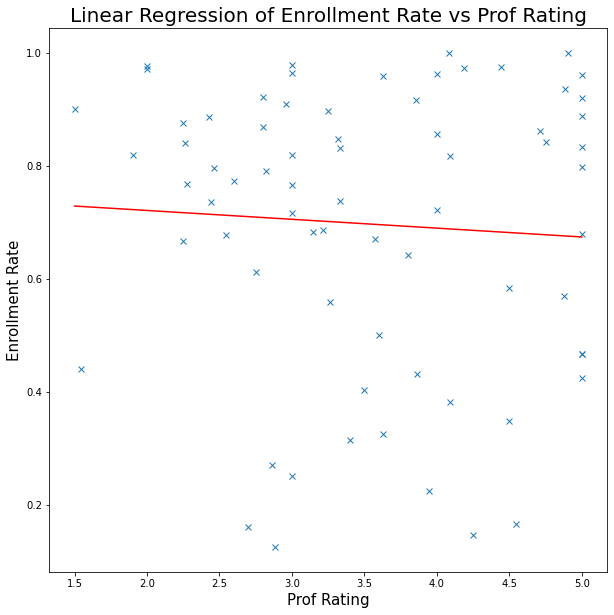

In [19]:
# Enrollment vs Prof Rating

from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

npMatrix = np.matrix(dummyProf)
X, Y = npMatrix[:,1], npMatrix[:,4]
model = LinearRegression().fit(X,Y)
slope_course_gpa = model.coef_[0]
b = model.intercept_

print ("Linear Regression: y = {0}x + {1}".format(slope_course_gpa, b))
result = sm.ols(formula="overall_enrollRate ~ avg_prof_rating", data=dummyProf).fit()
print(result.summary())

x_data = dummyProf['avg_prof_rating'].values
y_data = dummyProf ['overall_enrollRate'].values

x1 = np.linspace(x_data.min(), x_data.max(), 100)
y1 = x1*slope_course_gpa+b
plt.figure(figsize=(10,10))
plt.plot(x_data, y_data,'x',x1,y1,'r')
plt.title('Linear Regression of Enrollment Rate vs Prof Rating', fontsize = 20)
plt.xlabel("Prof Rating", fontsize=15)
plt.ylabel("Enrollment Rate", fontsize=15)
plt.show()

Looking at the regression results, it at first seems like there is a negative relationship between professor rating and course enrollment rate. However, when looking at the statistical output of our regression model, we can see that the P value for our relationship is `0.6`, which is extremely large, and therefore is not significant. So, we failed to see any linear relationship between these two variables at all.

# Linear Regression: Enrollment Rate vs Professor Average GPA

From another understanding from our peers, we would expect there to be a positive relationship between a professor's average gpa and course enrollment rate. In order to investigate this relationship, we will conduct another linear relationship:

Linear Regression: y = [0.07407593]x + [0.45661484]
                            OLS Regression Results                            
Dep. Variable:     overall_enrollRate   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.7911
Date:                Mon, 16 May 2022   Prob (F-statistic):              0.377
Time:                        20:01:17   Log-Likelihood:                -1.3985
No. Observations:                  71   AIC:                             6.797
Df Residuals:                      69   BIC:                             11.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

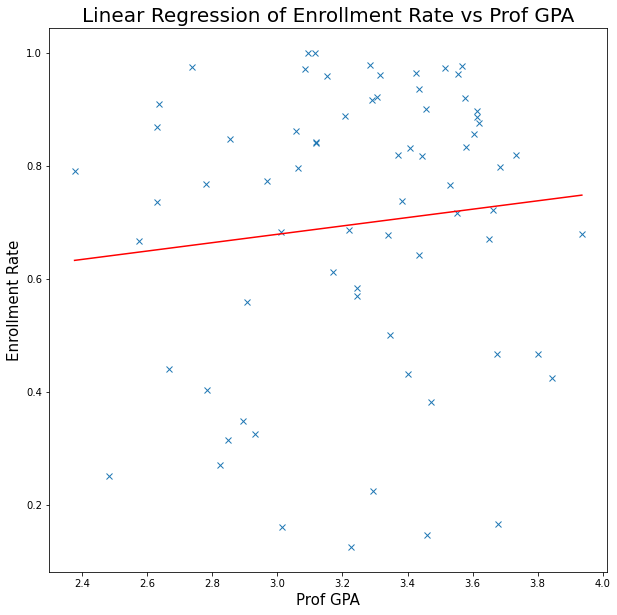

In [20]:
# Enrollment vs Prof GPA

from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

npMatrix = np.matrix(dummyProf)
X, Y = npMatrix[:,2], npMatrix[:,4]
model = LinearRegression().fit(X,Y)
slope_course_gpa = model.coef_[0]
b = model.intercept_

print ("Linear Regression: y = {0}x + {1}".format(slope_course_gpa, b))
result = sm.ols(formula="overall_enrollRate ~ avg_prof_gpa", data=dummyProf).fit()
print(result.summary())

x_data = dummyProf['avg_prof_gpa'].values
y_data = dummyProf ['overall_enrollRate'].values

x1 = np.linspace(x_data.min(), x_data.max(), 100)
y1 = x1*slope_course_gpa+b
plt.figure(figsize=(10,10))
plt.plot(x_data, y_data,'x',x1,y1,'r')
plt.title('Linear Regression of Enrollment Rate vs Prof GPA', fontsize = 20)
plt.xlabel("Prof GPA", fontsize=15)
plt.ylabel("Enrollment Rate", fontsize=15)
plt.show()

Unfortunately, looking at the regression results, it at again first seems like there is a positive relationship between professor rating and course enrollment rate. Yet, when looking at the output from the regression model, the P value is `0.377`, which again is large, making it not a significant result. We fail to see any relationship between professor average GPA and course enrollment rate.

# Linear Regression: Enrollment Rate vs Course Average GPA

Considering our Enrollment Rate vs Professor Average GPA did not yield significant results, let's take a look at the relatoonship between enrollment rate and course average GPA instead:

Linear Regression: y = [-0.0221303]x + [0.76252252]
                            OLS Regression Results                            
Dep. Variable:     overall_enrollRate   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                   0.05871
Date:                Mon, 16 May 2022   Prob (F-statistic):              0.809
Time:                        20:05:25   Log-Likelihood:                -1.7730
No. Observations:                  71   AIC:                             7.546
Df Residuals:                      69   BIC:                             12.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

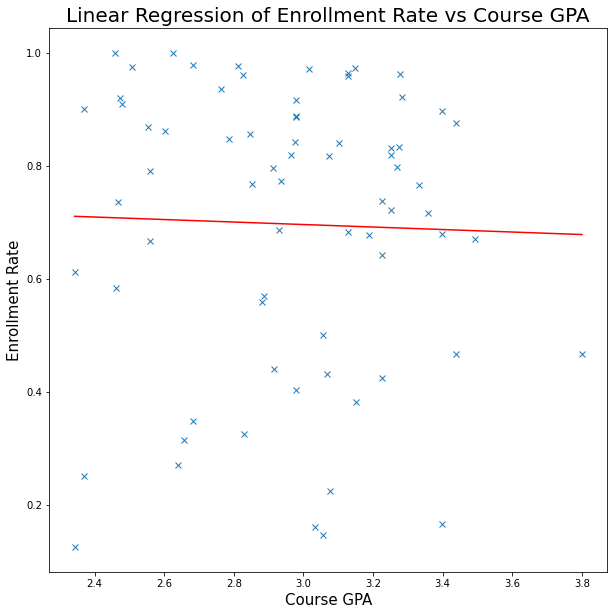

In [22]:
# Enrollment vs Course GPA

from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

npMatrix = np.matrix(dummyProf)
X, Y = npMatrix[:,3], npMatrix[:,4]
model = LinearRegression().fit(X,Y)
slope_course_gpa = model.coef_[0]
b = model.intercept_

print ("Linear Regression: y = {0}x + {1}".format(slope_course_gpa, b))
result = sm.ols(formula="overall_enrollRate ~ avg_course_gpa", data=dummyProf).fit()
print(result.summary())

x_data = dummyProf['avg_course_gpa'].values
y_data = dummyProf ['overall_enrollRate'].values

x1 = np.linspace(x_data.min(), x_data.max(), 100)
y1 = x1*slope_course_gpa+b
plt.figure(figsize=(10,10))
plt.plot(x_data, y_data,'x',x1,y1,'r')
plt.title('Linear Regression of Enrollment Rate vs Course GPA', fontsize = 20)
plt.xlabel("Course GPA", fontsize=15)
plt.ylabel("Enrollment Rate", fontsize=15)
plt.show()

Looking at the graph initially, there seems to be a slight negative relationship. However, upon inspecting the P-value again, it is `0.809`, making this result not significant either! >:(

# Final Try: A Linear Regression of All 3 Independent Variables

Considering we were unable to find a significant relationship between course average GPA, professor average GPA, or professor average rating to course enrollment rate, a final try on finding a relationship is to combine all of these factors, seeing if there is a hidden relationship that we are not seeing in individual regressions.

In [246]:
X = dummyProf[['avg_course_gpa', 'avg_prof_rating', 'avg_prof_gpa']]
Y = dummyProf['overall_enrollRate']
model = LinearRegression().fit(X,Y)
slope_course_gpa = model.coef_[0]
slope_avg_prof_rating = model.coef_[1]
slope_avg_prof_gpa = model.coef_[2]
b = model.intercept_
print ("Linear Regression: y = {0}x1 + {1}x2 + {2}x3 + {3}".format(slope_course_gpa, slope_avg_prof_rating, slope_avg_prof_gpa, b))
result = sm.ols(formula="overall_enrollRate ~ avg_course_gpa*avg_prof_rating*avg_prof_gpa", data=dummyProf).fit()
print(result.summary())

Linear Regression: y = -0.14704193562898163x1 + -0.03324784713935086x2 + 0.19804640855431882x3 + 0.6058969085422372
                            OLS Regression Results                            
Dep. Variable:     overall_enrollRate   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.294
Date:                Mon, 16 May 2022   Prob (F-statistic):              0.268
Time:                        19:21:40   Log-Likelihood:                 2.9651
No. Observations:                  71   AIC:                             10.07
Df Residuals:                      63   BIC:                             28.17
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [

Yet, as we can see in the regression results above, we see even worse P-values then what was observed in the previous linear regression results. It seems we were unable to come up with any type of significant relationship between these factors in the Computer Science Department. 

# Conclusion

Overall, we were unable to see any significant relationship between course average GPA, professor average GPA, or professor average rating to course enrollment rate. With these results, we believe that there is no direct relationship between these variables anywhere in our department, even though the general belief amongst our peers is that they are. What is more likely to be occurring throughout students within the Computer Science Department is a confirmation-bias relationship between these variables, and in reality, students are scheduling courses based on what fits their schedule and different requirements throughout the program.

However, we also are skeptical of this result, and still believe that there is likely some sort of relationship between these different factors. Thus, as we conclude, we suggest that you, the reader, take the initiative to proceed our analysis with additional conditions. For example, one condition we believe that may be at play in our analysis is that we are including department-required courses in our assessment. However, these courses most likely weigh heavily on the enrollment rates for specific instructors, even though they may not have the best rating, average GPA, or course average GPA. 

Another element to account for when continuing the analysis is that instructor ratings are almost certainly not normally distributed, with students typically only writing reviews on PlanetTerp if they have an extremely positive or extremely negative experience within a course. Thus, we suggest conducting sentiment analysis of the review text from the PlanetTerp API to better understand how student assessment can affect an instructor's enrollment rate.

Finally, course grades are typically curved in the Computer Science Department, which means that course average GPA and instrcutor average GPA may not actually be representative of the level of difficulty of a course, or how fair a certain instrcutor really is. Further, an additional consideration is that instructors are commonly not grading course material - it is typically Teaching Assistants, which may not be representative of the professer themselves.

In conclusion, we were disappointed with not finding any significant relationship between these variables. However, it gave us a better understanding of how these variables relate to each other, and made us consider more factors in how we will pick our courses in the future.

In [ ]:
import os
os.system('jupyter nbconvert --to html project.ipynb')